<a href="https://colab.research.google.com/github/benliebersohn/alg-ds-lab2/blob/master/Divorce%20with%20(M)GWR.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Preamble
This notebook was created for Spring 2021 with a lot of the code coming from the prior semester Fall 2020. This code was specified by Dr. Ziqi Li in the notebook "(M)GWR tutorial python.ipynb" which contains much of the structure and code you see here.

# Introduction
###How does single parents correlate to household income?
###Are poorer people more likely to be single parents?
***
This is a notebook which ias based on the GWR/MGWR example provided by Dr. Ziqi Li, intended to calibrate a GWR and an MGWR model in Python using `mgwr` package.
***
Single parents have a great burden to raise children while maintaining one income. This is made great challenge for poor single parents. While more wealthy women may have access to a range of birth control and childcare. It is still a challenge to get poorer people the social and medical services they need to maintain a stable future. While wealth is a stress on relationships, it is also a strain on the wellbeing of children (to not have childcare). This is not equally true, everywhere. For example, young parents in African American communities will often recieve support from their families. On the other hand, this cycle of poverty and single parenthood is challenging to break, but can be mitigated with properly directed support, because it impacts both our current and our future economic producutvity to have better raised children and less stressed parents. 
***
If we want to allocate more aid to single parents, where should it go? These maps illustrate how important the effects of poverty on single parenthood are. Of course like all cycles, it is hard to say which came first: "poverty or single parenthood?". In this case, I think it is fair to say that while we cannot provide extra parents, we can provide income and free childcare services to all single parent families.

#Model Justifications
Why did we use the parameters we used? In short, they were the best seperate approaches to single parenthood contributing to childhood poverty.
You can ask: We can already pull poverty+children from the census table, so why make this map? 
The answer is simply that we are not exploring the number of children. This is because a parent of one, or a parent of eight are both a parent. Additionally there is speculation that poor people have more children, which would impact our results. For now I am using the US Census definitions of husband (legal husband). This is to avoid exploring whether there might be a correlation between divorce and wealth or number of children and wealth.

#Model Specification
###families_pct_poor = 100*(families.poor/families.total)
This is a normalization of the number of poor families.
This is a percentage that handles the zeroes, of all families with 1 child under 18.

###pct_single= = pct_single_dad + single+pct_single_mom
pct single mom = DP02_0009PE
pct single dad = DP02_0007PE
This percentage is the sum of two percentages: of single men and women, (while other parent is absent) with children under 18.

#Motivation
### So far, we have not done justice upon single parents and their needs for raising kids. It is imperative we give these kids a better chance from all aspects in order to provide equity among future generations. 
Where is the connection between poverty and single parent strongest? These are places where single parents need resources, and other places where they don't need them as much.

In [334]:
#from google.colab import drive
#drive.mount('/content/drive')

In [335]:
!pip install mgwr
!pip install geopandas
!pip install censusdata

In [336]:
import sys
import csv
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
import geopandas as gpd
import pandas as pd
import libpysal as ps 
import censusdata

from mgwr.gwr import GWR,MGWR
from mgwr.sel_bw import Sel_BW

In [337]:
!unzip tl_2018_us_county.zip

Archive:  tl_2018_us_county.zip
replace tl_2018_us_county.cpg? [y]es, [n]o, [A]ll, [N]one, [r]ename: 

# Data
## Source: US Census Bureau
### Dataset: ACS 2018 5 Year Summary: Labor Force Status by Presence of a Computer and Types of Internet Subscription in Household
Table ID: B17010A
### Dataset: TIGER Lines 2018 Tracts, Illinois (ID 17)
Shapefile: tl_2018_17_tract.shp
### Area of interest: Illinois, USA
### Spatial unit: US Census Tract

In [ ]:
#censusdata.printtable(censusdata.censustable('acs5', 2018, 'DP02'))

In [ ]:
# The families pct poor was 100*(B17010A_002E/B17010A_001E)

In [ ]:
#status = censusdata.download('acs5', 2018, 
#                             censusdata.censusgeo([('state', '17'),
#                             ('county', '*',)]), ['DP02_0009PE', 'DP02_0007PE'],tabletype='profile')
                      # USE PROVIDED INSTEAD             
#status.describe()

status = gpd.read_file("status.csv")

In [ ]:
status

,state,county,tract,NAME,DP02_0009PE,DP02_0007PE,pct_single,poor,pct_poor,geometry
0,17,203,30100,"Census Tract 301, Woodford County, Illinois",5.2,1.1,6.3,548,5.213089802,None
1,17,201,101,"Census Tract 1.01, Winnebago County, Illinois",0,6.7,6.7,4704,7.784728428,None
2,17,199,20100,"Census Tract 201, Williamson County, Illinois",13.2,3.2,16.4,1574,9.570716284,None
3,17,197,880105,"Census Tract 8801.05, Will County, Illinois",4.1,3,7.1,5243,3.960657818,None
4,17,195,100,"Census Tract 1, Whiteside County, Illinois",4.5,0.5,5,1064,7.282683094,None
...,...,...,...,...,...,...,...,...,...,...
97,17,9,970400,"Census Tract 9704, Brown County, Illinois",2.3,0,2.3,81,6.428571429,None
98,17,7,10100,"Census Tract 101, Boone County, Illinois",15.6,3.6,19.2,945,7.587314332,None
99,17,5,951200,"Census Tract 9512, Bond County, Illinois",1.5,2.1,3.6,322,8.015932288,None
100,17,3,957600,"Census Tract 9576, Alexander County, Illinois",3.2,1.1,4.3,138,14.48058762,None


In [ ]:
counties = gpd.read_file("/content/tl_2018_us_county.shp") 
counties.head()

,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry
0,31,039,00835841,31039,Cuming,Cuming County,06,H1,G4020,None,None,None,A,1477652222,10690952,+41.9158651,-096.7885168,"POLYGON ((-97.01952 42.00410, -97.01952 42.004..."
1,53,069,01513275,53069,Wahkiakum,Wahkiakum County,06,H1,G4020,None,None,None,A,680956809,61588406,+46.2946377,-123.4244583,"POLYGON ((-123.43639 46.23820, -123.44759 46.2..."
2,35,011,00933054,35011,De Baca,De Baca County,06,H1,G4020,None,None,None,A,6016819484,29089486,+34.3592729,-104.3686961,"POLYGON ((-104.56739 33.99757, -104.56772 33.9..."
3,31,109,00835876,31109,Lancaster,Lancaster County,06,H1,G4020,339,30700,None,A,2169287528,22832516,+40.7835474,-096.6886584,"POLYGON ((-96.91075 40.78494, -96.91075 40.790..."
4,31,129,00835886,31129,Nuckolls,Nuckolls County,06,H1,G4020,None,None,None,A,1489645187,1718484,+40.1764918,-098.0468422,"POLYGON ((-98.27367 40.08940, -98.27367 40.089..."


In [ ]:
Shapefile = gpd.GeoDataFrame(pd.merge(status,counties,how="left",left_on="county",right_on="COUNTYFP"))
Shapefile['geometry']=Shapefile['geometry_y']

In [ ]:
Shapefile

,state,county,tract,NAME_x,DP02_0009PE,DP02_0007PE,pct_single,poor,pct_poor,geometry_x,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME_y,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry_y,geometry
0,17,203,30100,"Census Tract 301, Woodford County, Illinois",5.2,1.1,6.3,548,5.213089802,None,48,203,01383887,48203,Harrison,Harrison County,06,H1,G4020,346,32220,None,A,2.330874e+09,40916169.0,+32.5479914,-094.3744344,"POLYGON ((-94.70183 32.60781, -94.70182 32.614...","POLYGON ((-94.70183 32.60781, -94.70182 32.614..."
1,17,203,30100,"Census Tract 301, Woodford County, Illinois",5.2,1.1,6.3,548,5.213089802,None,17,203,01785231,17203,Woodford,Woodford County,06,H1,G4020,427,37900,None,A,1.366946e+09,38461366.0,+40.7897870,-089.2105871,"POLYGON ((-89.04772 40.92575, -89.04630 40.925...","POLYGON ((-89.04772 40.92575, -89.04630 40.925..."
2,17,203,30100,"Census Tract 301, Woodford County, Illinois",5.2,1.1,6.3,548,5.213089802,None,29,203,00758554,29203,Shannon,Shannon County,06,H1,G4020,None,None,None,A,2.599884e+09,464012.0,+37.1524984,-091.3913284,"POLYGON ((-91.60568 37.42195, -91.60562 37.421...","POLYGON ((-91.60568 37.42195, -91.60562 37.421..."
3,17,203,30100,"Census Tract 301, Woodford County, Illinois",5.2,1.1,6.3,548,5.213089802,None,21,203,00516948,21203,Rockcastle,Rockcastle County,06,H1,G4020,336,40080,None,A,8.198539e+08,4011241.0,+37.3610502,-084.3143684,"POLYGON ((-84.37444 37.47266, -84.37434 37.472...","POLYGON ((-84.37444 37.47266, -84.37434 37.472..."
4,17,203,30100,"Census Tract 301, Woodford County, Illinois",5.2,1.1,6.3,548,5.213089802,None,20,203,00485062,20203,Wichita,Wichita County,06,H1,G4020,None,None,None,A,1.861078e+09,61987.0,+38.4819222,-101.3474341,"POLYGON ((-101.56749 38.26337, -101.56748 38.2...","POLYGON ((-101.56749 38.26337, -101.56748 38.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,17,9,970400,"Census Tract 9704, Brown County, Illinois",2.3,0,2.3,81,6.428571429,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1001,17,7,10100,"Census Tract 101, Boone County, Illinois",15.6,3.6,19.2,945,7.587314332,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1002,17,5,951200,"Census Tract 9512, Bond County, Illinois",1.5,2.1,3.6,322,8.015932288,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1003,17,3,957600,"Census Tract 9576, Alexander County, Illinois",3.2,1.1,4.3,138,14.48058762,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None


In [ ]:
# Important step: Drop NA values by dropping any tracts without data
#Shapefile = Shapefile.dropna(axis = 0, how = 'any')

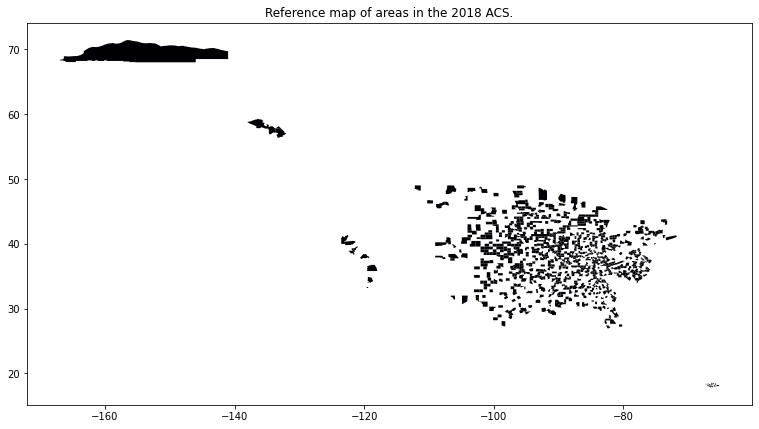

In [342]:
Shapefile.plot(column="state",legend=False, cmap="magma", figsize=(13,13))

plt.title("Reference map of areas in the 2018 ACS.")
plt.show()

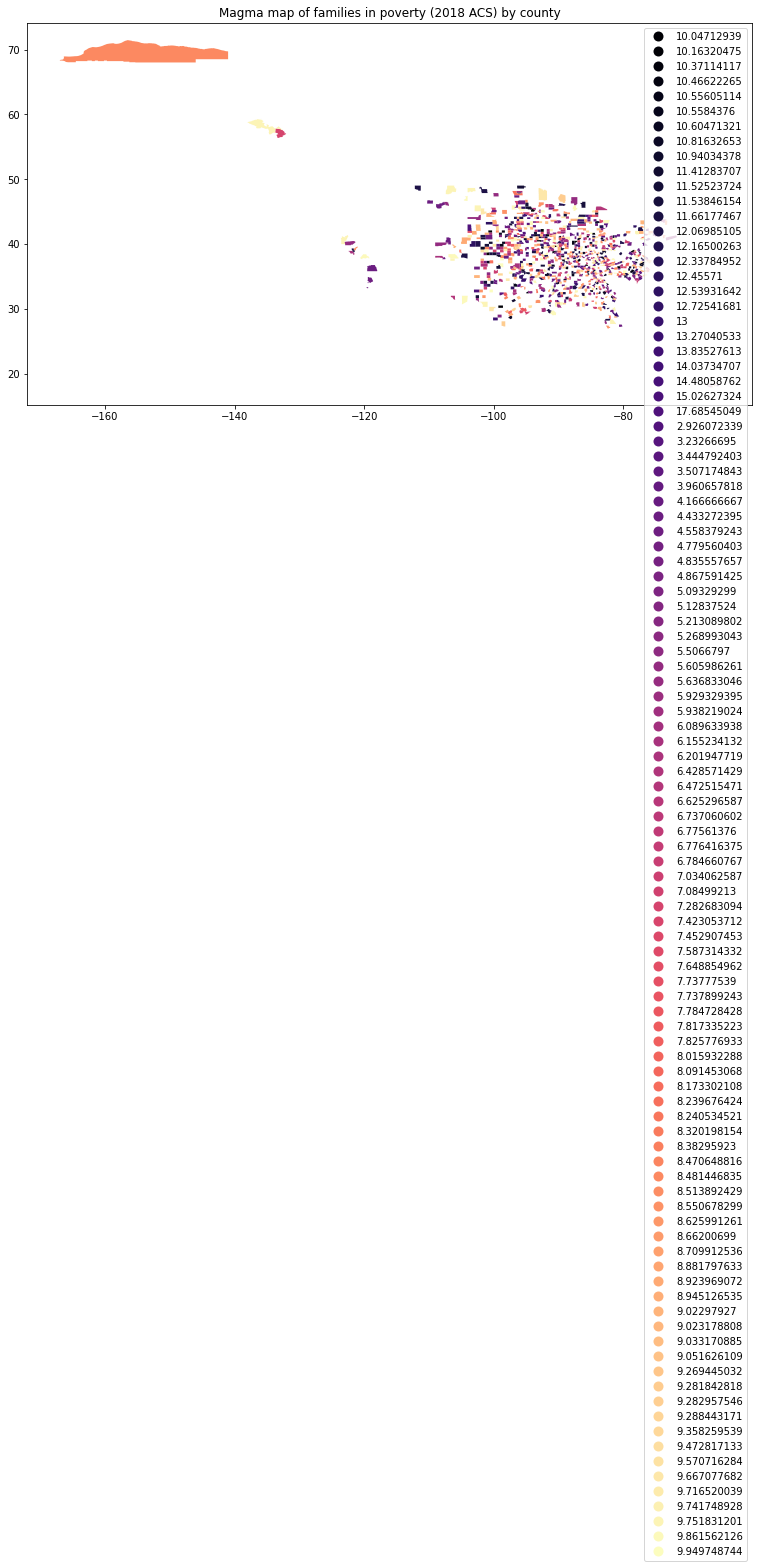

In [324]:
Shapefile.plot(column="pct_poor",legend=True, cmap="magma", figsize=(13,13))

plt.title("Magma map of families in poverty (2018 ACS) by county")
plt.show()

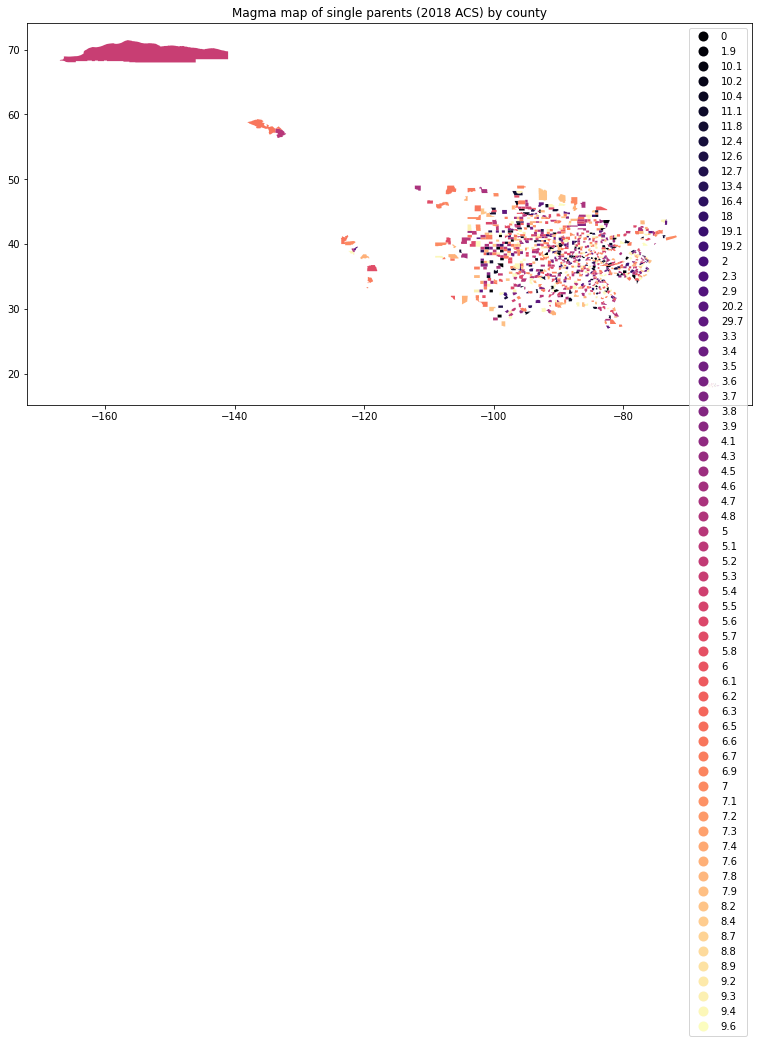

In [329]:
Shapefile.plot(column="pct_single",legend=True, cmap="magma", figsize=(13,13))

plt.title("Magma map of single parents (2018 ACS) by county")
plt.show()

## Model Specification

In [328]:
centroids = []
crs = []
centroids = Shapefile.centroid

/usr/local/lib/python3.7/dist-packages/ipykernel_launcher.py:3: UserWarning: Geometry is in a geographic CRS. Results from 'centroid' are likely incorrect. Use 'GeoSeries.to_crs()' to re-project geometries to a projected CRS before this operation.

  This is separate from the ipykernel package so we can avoid doing imports until


In [437]:
Shapefile

,state,county,tract,NAME_x,DP02_0009PE,DP02_0007PE,pct_single,poor,pct_poor,geometry_x,STATEFP,COUNTYFP,COUNTYNS,GEOID,NAME_y,NAMELSAD,LSAD,CLASSFP,MTFCC,CSAFP,CBSAFP,METDIVFP,FUNCSTAT,ALAND,AWATER,INTPTLAT,INTPTLON,geometry_y,geometry
0,17,203,30100,"Census Tract 301, Woodford County, Illinois",5.2,1.1,6.3,548,5.213089802,None,48,203,01383887,48203,Harrison,Harrison County,06,H1,G4020,346,32220,None,A,2.330874e+09,40916169.0,+32.5479914,-094.3744344,"POLYGON ((-94.70183 32.60781, -94.70182 32.614...","POLYGON ((-94.70183 32.60781, -94.70182 32.614..."
1,17,203,30100,"Census Tract 301, Woodford County, Illinois",5.2,1.1,6.3,548,5.213089802,None,17,203,01785231,17203,Woodford,Woodford County,06,H1,G4020,427,37900,None,A,1.366946e+09,38461366.0,+40.7897870,-089.2105871,"POLYGON ((-89.04772 40.92575, -89.04630 40.925...","POLYGON ((-89.04772 40.92575, -89.04630 40.925..."
2,17,203,30100,"Census Tract 301, Woodford County, Illinois",5.2,1.1,6.3,548,5.213089802,None,29,203,00758554,29203,Shannon,Shannon County,06,H1,G4020,None,None,None,A,2.599884e+09,464012.0,+37.1524984,-091.3913284,"POLYGON ((-91.60568 37.42195, -91.60562 37.421...","POLYGON ((-91.60568 37.42195, -91.60562 37.421..."
3,17,203,30100,"Census Tract 301, Woodford County, Illinois",5.2,1.1,6.3,548,5.213089802,None,21,203,00516948,21203,Rockcastle,Rockcastle County,06,H1,G4020,336,40080,None,A,8.198539e+08,4011241.0,+37.3610502,-084.3143684,"POLYGON ((-84.37444 37.47266, -84.37434 37.472...","POLYGON ((-84.37444 37.47266, -84.37434 37.472..."
4,17,203,30100,"Census Tract 301, Woodford County, Illinois",5.2,1.1,6.3,548,5.213089802,None,20,203,00485062,20203,Wichita,Wichita County,06,H1,G4020,None,None,None,A,1.861078e+09,61987.0,+38.4819222,-101.3474341,"POLYGON ((-101.56749 38.26337, -101.56748 38.2...","POLYGON ((-101.56749 38.26337, -101.56748 38.2..."
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1000,17,9,970400,"Census Tract 9704, Brown County, Illinois",2.3,0,2.3,81,6.428571429,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1001,17,7,10100,"Census Tract 101, Boone County, Illinois",15.6,3.6,19.2,945,7.587314332,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1002,17,5,951200,"Census Tract 9512, Bond County, Illinois",1.5,2.1,3.6,322,8.015932288,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None
1003,17,3,957600,"Census Tract 9576, Alexander County, Illinois",3.2,1.1,4.3,138,14.48058762,None,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,None,None


In [513]:
#Prepare Georgia dataset inputs
y = Shapefile['pct_poor'].values
X = Shapefile['pct_single'].values


In [514]:
u = Shapefile['geometry_x']
v = Shapefile['geometry_y']

coords = list(zip(u,v))

In [519]:
i=0
for item in X:
  if item is not float:
    print(item,"is string")
  print(X[i])
  i+=1

print("Done with X, there are:", i, " elements")

6.3 is string
6.3
6.3 is string
6.3
6.3 is string
6.3
6.3 is string
6.3
6.3 is string
6.3
6.7 is string
6.7
6.7 is string
6.7
6.7 is string
6.7
6.7 is string
6.7
6.7 is string
6.7
6.7 is string
6.7
16.4 is string
16.4
16.4 is string
16.4
16.4 is string
16.4
16.4 is string
16.4
16.4 is string
16.4
16.4 is string
16.4
16.4 is string
16.4
16.4 is string
16.4
7.1 is string
7.1
7.1 is string
7.1
7.1 is string
7.1
7.1 is string
7.1
7.1 is string
7.1
7.1 is string
7.1
7.1 is string
7.1
7.1 is string
7.1
7.1 is string
7.1
5 is string
5
5 is string
5
5 is string
5
5 is string
5
5 is string
5
5 is string
5
5 is string
5
5 is string
5
5 is string
5
5 is string
5
12.4 is string
12.4
12.4 is string
12.4
12.4 is string
12.4
12.4 is string
12.4
12.4 is string
12.4
12.4 is string
12.4
12.4 is string
12.4
12.4 is string
12.4
5.8 is string
5.8
5.8 is string
5.8
5.8 is string
5.8
5.8 is string
5.8
5.8 is string
5.8
5.8 is string
5.8
5.8 is string
5.8
5.8 is string
5.8
7.3 is string
7.3
7.3 is string
7.3


In [563]:
i=0
for item in y:
  if item == '0':
    print("x at i:", X[i])
    X[i] += 0.001
    print("now", X[i])

  i+=1

print("Done with Z, there are:", i, " elements")

Done with Z, there are: 1005  elements


In [566]:
i=0
for item in coords:
  print(item)
  if item[0] == '0':
    print("x at i:", item)
  if item[1] == '0':
    print("y is at i:", item)

  i+=1
coords.dropna()
print("Done with Z, there are:", i, " elements")

(None, <shapely.geometry.polygon.Polygon object at 0x7f98fcb04110>)
(None, <shapely.geometry.polygon.Polygon object at 0x7f98fc5b2c10>)
(None, <shapely.geometry.polygon.Polygon object at 0x7f98fc83be10>)
(None, <shapely.geometry.polygon.Polygon object at 0x7f98fc61a9d0>)
(None, <shapely.geometry.polygon.Polygon object at 0x7f98fc3549d0>)
(None, <shapely.geometry.polygon.Polygon object at 0x7f98fcb75790>)
(None, <shapely.geometry.polygon.Polygon object at 0x7f98fcd81910>)
(None, <shapely.geometry.polygon.Polygon object at 0x7f98fe467f50>)
(None, <shapely.geometry.polygon.Polygon object at 0x7f98fc573910>)
(None, <shapely.geometry.polygon.Polygon object at 0x7f98fc691bd0>)
(None, <shapely.geometry.polygon.Polygon object at 0x7f98fc82ac10>)
(None, <shapely.geometry.polygon.Polygon object at 0x7f98fcd92950>)
(None, <shapely.geometry.polygon.Polygon object at 0x7f98fcd16c10>)
(None, <shapely.geometry.polygon.Polygon object at 0x7f98fee818d0>)
(None, <shapely.geometry.polygon.Polygon object 

AttributeError: ignored

### Standardizing varaibles
- Standardizing put the data at the same scale: mean of 0 and variance of 1
- The magnitudes of the parameter estimates are comparable. Larger magnitude -> stronger relationship
- If you calibrate an MGWR model, we have to standardize the data. Each bandwidth would describe the degree of spatial variation of each relationship.

In [560]:
#Standardize variables
for item in X:
  if item is not float:
    continue 
  if item is float:
    X = (X - X.mean(axis=0)) / X.std(axis=0)
    y = (y - y.mean(axis=0)) / y.std(axis=0)
    y = y.reshape(-1,1)

### Fitting a GWR model
- Select the optimal bandwidths
- Fit the model

In [529]:
print(coords, y, X)

[(None, <shapely.geometry.polygon.Polygon object at 0x7f98fcb04110>), (None, <shapely.geometry.polygon.Polygon object at 0x7f98fc5b2c10>), (None, <shapely.geometry.polygon.Polygon object at 0x7f98fc83be10>), (None, <shapely.geometry.polygon.Polygon object at 0x7f98fc61a9d0>), (None, <shapely.geometry.polygon.Polygon object at 0x7f98fc3549d0>), (None, <shapely.geometry.polygon.Polygon object at 0x7f98fcb75790>), (None, <shapely.geometry.polygon.Polygon object at 0x7f98fcd81910>), (None, <shapely.geometry.polygon.Polygon object at 0x7f98fe467f50>), (None, <shapely.geometry.polygon.Polygon object at 0x7f98fc573910>), (None, <shapely.geometry.polygon.Polygon object at 0x7f98fc691bd0>), (None, <shapely.geometry.polygon.Polygon object at 0x7f98fc82ac10>), (None, <shapely.geometry.polygon.Polygon object at 0x7f98fcd92950>), (None, <shapely.geometry.polygon.Polygon object at 0x7f98fcd16c10>), (None, <shapely.geometry.polygon.Polygon object at 0x7f98fee818d0>), (None, <shapely.geometry.polygon.

In [571]:
#Select the optimal bandwidth
gwr_selector = Sel_BW(coords, y, X)
gwr_bw = gwr_selector.search(bw_min=100)
print("Selected optimal bandwidth is:", gwr_bw)

/usr/local/lib/python3.7/dist-packages/mgwr/sel_bw.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.coords = np.array(coords)


IndexError: ignored

In [572]:
gwr_bw = 100

In [550]:
#Fit the model using the optimal bw
gwr_results = GWR(coords, y, X, 2).fit()

TypeError: ignored

In [567]:
gwr_bw = 115
gwr_results = GWR(coords, y, X, gwr_bw).fit()

TypeError: ignored

In [568]:
gwr_results.summary()

AttributeError: ignored

### Write some mapping codes

In [573]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from mgwr.utils import shift_colormap,truncate_colormap
from matplotlib import cm,colors

def gwr_plots(result, gdf, names=[], filter_t=False):
    
    fig, axs = plt.subplots(2,2, figsize=(10, 10))
    axs = axs.ravel()
    
    k = gwr_results.k
    
    vmin = -0.8
    vmax = 0.8
    
    cmap = cm.get_cmap("coolwarm")
    norm = colors.BoundaryNorm(np.arange(-0.8,0.85,0.1),ncolors=256)
    
    if (vmin < 0) & (vmax < 0):
        cmap = truncate_colormap(cmap, 0.0, 0.5)
    elif (vmin > 0) & (vmax > 0):
        cmap = truncate_colormap(cmap, 0.5, 1.0)
    else:
        cmap = shift_colormap(cmap, start=0.0, midpoint=1 - vmax/(vmax + abs(vmin)), stop=1.)

    for j in range(k):
        
        pd.concat([gdf,pd.DataFrame(np.hstack([result.params,result.bse]))],axis=1).plot(ax=axs[j],column=j,vmin=vmin,vmax=vmax,
                                                                                         cmap="bwr",norm=norm,linewidth=0.1,edgecolor='white')
        axs[j].set_title("Parameter estimates of \n" + names[j],fontsize=10)
        
        if filter_t:
            rslt_filtered_t = result.filter_tvals()
            if (rslt_filtered_t[:,j] == 0).any():
                gdf[rslt_filtered_t[:,j] == 0].plot(color='lightgrey', ax=axs[j],linewidth=0.1,edgecolor='white')
        
        #plt.axis('off')
    
    fig = axs[j].get_figure()
    cax = fig.add_axes([0.99, 0.2, 0.025, 0.6])
    sm = plt.cm.ScalarMappable(cmap=cmap,norm=norm)
    # fake up the array of the scalar mappable. Urgh...
    sm._A = []
    fig.colorbar(sm, cax=cax)

#### Here are the maps of parameter estimates obtained from GWR. Each represent the spatial relationship between each predictor and pct_in_laborforce.

#### Positive (negative) relationships are shown in red (blue).
#### Stronger relationship has a darker color.

In [575]:
gwr_plots(pct_single, pct_poor,names=['pct_poor', 'pct_single'])

# pct_in_laborforce
# pct_laborforce_w_broadband

NameError: ignored

#### Here are the maps of **SIGNIFICANT (p<0.05)** parameter estimates. Grey locations are insignificant.


In [ ]:
gwr_plots(gwr_results, internet_tracts,names=['pct_in_laborforce', 'pct_laborforce_w_broadband'],filter_t=True)
# pct_in_laborforce
# pct_laborforce_w_broadband

### Fitting the MGWR model
- Select the optimal bandwidths
- Fit the model

In [569]:
mgwr_selector = Sel_BW(coords, y, X, multi=True)
mgwr_bw = mgwr_selector.search(multi_bw_min=[2])
print(mgwr_bw)

/usr/local/lib/python3.7/dist-packages/mgwr/sel_bw.py:179: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray
  self.coords = np.array(coords)


IndexError: ignored

In [ ]:
mgwr_results = MGWR(coords, y, X, mgwr_selector).fit()

In [ ]:
mgwr_results.summary()

todo: clean the notebook, remove exploratory code
Make model specification more clear
What is my dependent, independent variable

Model comparison


|      | OLS   | GWR   | MGWR |   |
|------|-------|-------|------|---|
| AICc | 335   | 299   | 297  |   |
| R2   | 0.548 | 0.678 | 0.68 |   |
|      |       |       |      |   |

In [ ]:
gwr_plots(mgwr_results, internet_tracts,names=['pct_employed_w_broadband', 'pct_employed'])

In [ ]:
gwr_plots(mgwr_results, internet_tracts,names=['pct_employed_w_broadband', 'pct_employed'],filter_t=True)

# Results
The primary takeaway is that it is very challenging to figure out whether something is a cause, or an effect.
With this in mind, what may be an effect in one place may be a cause in another. Additionally, it is very challenging to get data outside of an urban area. This may sound like it is not a big problem, but it means that the rural demographics go understudied because it is not possible to make statistically signifigant conclusions about such a sparse population. How do we combat poverty and a discouraged workforce, especially now that many people have given up on jobs until it is safe to work? 

This is to say I believe the areas where people are able to raise children together (such as African American communities) are more resilient during pandemics and recessions, and do not find the same challenges that the white and foreign families find - such as no family supported childcare during a pandemic. These disparities are very clear to me in CU, where many students are stranded; wheras for the rest of the community life goes on as normal. This is not a not statistically signifigant correlations, however what it teaches me is that each place is different, albeit related to other places. Each pandemic response has been different, and this has demonstrated to us that we are part of an interconnected fabric of community, continuously connected from children to far away friends. This has in part been enabled by the rise of a global social media, but also from changing trends among younger generations. People my age are enticed by cheap airline tickets and encouragement from our peers. Globalization has negative correlations. Xenophobia has turned within, sometimes we have more bias against people from nearby places than from faraway places. 
In conclusion, I have learned that it is not possible to determine whether it is poverty in the household that leads to divorce, or whether there is a specific "cause" to divorce at all. While I would like to prevent divorce, it has been a learning experience for me to see how my friends who have divorced parents actually *prefer* them in a divorced status (rather than arguing). My assumptions about the effects of divorce (stress) are not as important as I had initially presumed. 

In order to learn the effects of poverty on divorce, I believe I will need a dataset which tracks a population as it goes into poverty, in order to look to see if divorce trends rise. From my map it does not apear that any clear trends are emerging (there are no hot-spots for divorce) so it might take this long term approach to learn more about the effects of wealth on marrige.
***
